In [642]:
# DS essentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# python support
import re
import string
import datetime
import pickle 
from collections import Counter

# visualizations
from wordcloud import WordCloud
from nltk import FreqDist

# NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import words, stopwords, wordnet
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer 
#nltk.download('stopwords') -- need to download the first time you run the cell
#nltk.download('wordnet') -- need to download the first time you run the cell
 
# sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle

In [487]:
# !pip install tweet-preprocessor
import preprocessor as p

In [488]:
df_raw = pd.read_csv('JoeBidenTweets_Oct31.csv')

In [489]:
df_raw.head(3)

,id,timestamp,url,tweet,replies,retweets,quotes,likes
0,1.121350e+18,4/25/19 10:00,https://twitter.com/JoeBiden/status/1121353260...,The core values of this nation… our standing i...,18115,27217,10198,94224
1,1.121360e+18,4/25/19 10:39,https://twitter.com/JoeBiden/status/1121363091...,Hoy estoy anunciando mi candidatura para presi...,1007,2487,519,8720
2,1.121430e+18,4/25/19 14:51,https://twitter.com/JoeBiden/status/1121426527...,"Our country is being put to the test, but I’ve...",1371,3286,442,14918


This dataframe consists of all of Joe Biden's election tweets from April 25, 2019 to October 30, 2020.

In [490]:
cols = df_raw.columns.tolist()

df_raw = df_raw.reindex(columns=cols)

tweets = df_raw.drop(columns=['id', 'url'])

In [491]:
tweets.head(3)

,timestamp,tweet,replies,retweets,quotes,likes
0,4/25/19 10:00,The core values of this nation… our standing i...,18115,27217,10198,94224
1,4/25/19 10:39,Hoy estoy anunciando mi candidatura para presi...,1007,2487,519,8720
2,4/25/19 14:51,"Our country is being put to the test, but I’ve...",1371,3286,442,14918


### Preprocessing

I first want to remove punctuation, numbers, RTs, hyperlinks, short words, symbols, and emojis.

In [492]:
def preprocess_tweet(row):
    text = row['tweet']
    text = p.clean(text) #clean to normal text removes hashtags and emojis
    text = re.sub(r'[^\w]', ' ', text) #Removes all symbols
    text = text.lower() # lowercases all words
    text = re.sub(r'\d+', '', text) # Removes numbers
    text = re.sub('RT[\s]+', '', text) # Removing RT
    text = re.sub('https?:\/\/\S+', '', text) # Removing hyperlink
    text = re.sub(r'\W*\b\w{1,2}\b', '', text) #Removes words between 1 and 2 characters short
    return text
tweets['clean'] = tweets.apply(preprocess_tweet, axis=1)

In [493]:
tweets['clean'].iloc[0]

'the core values this nation our standing the world our very democracy   everything that has made america    america stake  thats why today announcing candidacy for president the united states '

In [494]:
tweets.head()

,timestamp,tweet,replies,retweets,quotes,likes,clean
0,4/25/19 10:00,The core values of this nation… our standing i...,18115,27217,10198,94224,the core values this nation our standing the w...
1,4/25/19 10:39,Hoy estoy anunciando mi candidatura para presi...,1007,2487,519,8720,hoy estoy anunciando candidatura para presiden...
2,4/25/19 14:51,"Our country is being put to the test, but I’ve...",1371,3286,442,14918,our country being put the test but ive never ...
3,4/25/19 17:00,"Folks, earlier today I announced that I’m runn...",1698,3589,436,19515,folks earlier today announced that running fo...
4,4/25/19 20:45,Our campaign is off to a great start thanks to...,1031,2257,185,12486,our campaign off great start thanks thousands ...


### Standardize Language

I now want to remove any non-English tweets. He has several tweets in Spanish which are immediately following their English versions.

In [484]:
from langdetect import detect

def english_only(x):
    """
    Take tweet, detect language, and only return English tweets, coding foreign language tweets as NaNs.
    """
    try:
        if detect(x) == 'en':
            return x
        else:
            return np.nan
    except:
        pass

In [495]:
%%time
#  Remove any non english tweets
tweets['clean'] = tweets['clean'].apply(lambda x: english_only(x))

CPU times: user 32.2 s, sys: 312 ms, total: 32.5 s
Wall time: 33.6 s


In [496]:
tweets.clean.isnull().sum()

148

In [497]:
#drop non-English tweets
tweets = tweets[tweets.clean.notnull()]

In [498]:
tweets.clean.isnull().sum()

0

### Tokenize

I now want each word to be a single token and then lemmatize them, i.e. keep only only the root word for a verb and not the other versions.

In [499]:
tt = TreebankWordTokenizer()
tweets['clean'] = tweets['clean'].apply(tt.tokenize)

In [500]:
tweets['clean'].iloc[0]

['the',
 'core',
 'values',
 'this',
 'nation',
 'our',
 'standing',
 'the',
 'world',
 'our',
 'very',
 'democracy',
 'everything',
 'that',
 'has',
 'made',
 'america',
 'america',
 'stake',
 'thats',
 'why',
 'today',
 'announcing',
 'candidacy',
 'for',
 'president',
 'the',
 'united',
 'states']

### Lemmatize

In [501]:
lemmatizer = WordNetLemmatizer()
tweets['clean'] = tweets['clean'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x]) # Lemmatize every word.

In [502]:
tweets['clean'].iloc[0]

['the',
 'core',
 'value',
 'this',
 'nation',
 'our',
 'standing',
 'the',
 'world',
 'our',
 'very',
 'democracy',
 'everything',
 'that',
 'ha',
 'made',
 'america',
 'america',
 'stake',
 'thats',
 'why',
 'today',
 'announcing',
 'candidacy',
 'for',
 'president',
 'the',
 'united',
 'state']

## Remove Stop Words

I now want to remove the standard list of "stop words," or words with little meaning on their own, e.g. _the_, _is_, _at_, _on_.

In [503]:
#removes default stop_words
stop_words = list(stopwords.words('english'))

In [504]:
newStopWords = ['ha','wa', 'ive', 'ill' ,'abc']
stop_words.extend(newStopWords)

In [505]:
#stop_words = set(stopwords.words('english'))
tweets['clean'] = tweets['clean'].apply(lambda x: [word for word in x if word not in stop_words])

In [506]:
tweets['clean'].iloc[0]

['core',
 'value',
 'nation',
 'standing',
 'world',
 'democracy',
 'everything',
 'made',
 'america',
 'america',
 'stake',
 'thats',
 'today',
 'announcing',
 'candidacy',
 'president',
 'united',
 'state']

In [507]:
tweets['clean'].sample(20)

3873    [believe, much, better, saw, week, rnc, moment...
47      [first, day, ramadan, jill, wish, peace, happi...
3607          [john, lewis, left, marching, order, carry]
1296    [speaker, right, trump, senate, republican, st...
4259                                         [wear, mask]
3423    [america, cant, sit, sideline, race, future, a...
1285    [donald, trump, inherited, growing, economy, o...
1576    [enough, wish, world, better, make, belief, gu...
202     [three, year, later, horrific, attack, pulse, ...
3156    [day, election, day, stake, never, higher, def...
4417    [ensure, right, lgbtq, people, protected, law,...
4386    [president, trump, way, supreme, court, long, ...
773     [thank, everyone, came, town, hall, spartanbur...
158     [today, anniversary, china, brutal, crackdown,...
4107    [asking, money, isnt, favorite, part, running,...
1322    [ten, year, ago, president, obama, championed,...
4584    [president, trump, administration, may, quit, ...
4558    [ten, 

## Vectorize

The first part of the vectorization process is to put the clean list of words as their own column in the dataframe.

In [508]:
tweets['clean'] = tweets['clean'].apply(lambda x: ' '.join(x))
tweets['clean']

0       core value nation standing world democracy eve...
2       country put test never optimistic america toge...
3       folk earlier today announced running president...
4       campaign great start thanks thousand american ...
5       update close book amazing first day campaign l...
                              ...                        
4718           president build economy reward work wealth
4719                         let put dog back white house
4720    hand ultimate power power vote dont let waste ...
4721    need build bridge wall open arm clench fist fo...
4722    jodie word always stand million american pre e...
Name: clean, Length: 4575, dtype: object

In [509]:
tweets.head()

,timestamp,tweet,replies,retweets,quotes,likes,clean
0,4/25/19 10:00,The core values of this nation… our standing i...,18115,27217,10198,94224,core value nation standing world democracy eve...
2,4/25/19 14:51,"Our country is being put to the test, but I’ve...",1371,3286,442,14918,country put test never optimistic america toge...
3,4/25/19 17:00,"Folks, earlier today I announced that I’m runn...",1698,3589,436,19515,folk earlier today announced running president...
4,4/25/19 20:45,Our campaign is off to a great start thanks to...,1031,2257,185,12486,campaign great start thanks thousand american ...
5,4/25/19 22:40,UPDATE: We’re about to close the books on an A...,947,731,81,3879,update close book amazing first day campaign l...


In [510]:
tweets.dtypes

timestamp    object
tweet        object
replies       int64
retweets      int64
quotes        int64
likes         int64
clean        object
dtype: object

I also need to change the **timestamp** field to a datetime object in the right format.

In [511]:
tweets['timestamp'] =  pd.to_datetime(tweets['timestamp'])

In [512]:
tfidf = TfidfVectorizer(max_df = 0.3, min_df = 0.0001) #moving max_df down to 0.2 only eliminates 2 words
doc_term_matrix = tfidf.fit_transform(tweets['clean'])

In [513]:
df = pd.DataFrame(doc_term_matrix.toarray(), columns=tfidf.get_feature_names())

In [514]:
df

,aanhpi,aapi,aapis,aarp,abandon,abandoned,abandoning,abase,abdicated,abdication,...,youre,youth,youtubers,youve,yovanovitch,zero,zeta,zip,zone,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4573,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Here's the vectorized dataframe of all the words, which as you can see here is 6,456 columns wide, one column for each unique word.

In [515]:
clean_tweets = tweets[['clean']]

In [516]:
clean_tweets.head()

,clean
0,core value nation standing world democracy eve...
2,country put test never optimistic america toge...
3,folk earlier today announced running president...
4,campaign great start thanks thousand american ...
5,update close book amazing first day campaign l...


In [842]:
clean_tweets.clean[0]

'core value nation standing world democracy everything made america america stake thats today announcing candidacy president united state'

## Topic Modeling

Now time to topic model.

#### KMeans Clustering

In [517]:
from sklearn.cluster import KMeans

In [523]:
inertias = []

for k_ in np.arange(1, 16):
    km = KMeans(n_clusters=k_)
    km.fit(doc_term_matrix)
    inertia = km.inertia_
    inertias.append(km.inertia_)

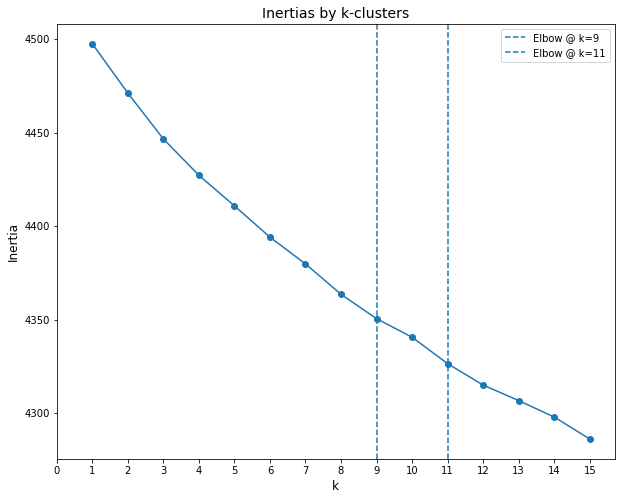

In [525]:
%matplotlib inline
plt.figure(figsize=(10, 8))
plt.plot(np.arange(1, 16), inertias, marker='o')
plt.axvline(x=9, ls='--', label='Elbow @ k=9')
plt.axvline(x=11, ls='--', label='Elbow @ k=11')
plt.xticks(np.arange(0, 16, step=1))
plt.title('Inertias by k-clusters', fontsize=14)
plt.ylabel("Inertia", fontsize=12)
plt.xlabel('k', fontsize=12)
plt.legend();

It looks like 10 (k=9, since we add the 0) or 12 (k=11) topics are a good place to start.

In [526]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

In [527]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for idx, topic in enumerate(model.components_):
        if not topic_names or not topic_names[idx]:
            print("\nTopic ", idx)
        else:
            print("\nTopic: '",topic_names[idx],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

#### LSA

In [849]:
# I tried LSA but the topics were very unclear. I'm commenting out the code so it doesn't run again.

lsa = TruncatedSVD(13)
doc_topic = lsa.fit_transform(doc_term_matrix)
lsa.explained_variance_ratio_

display_topics(lsa, tfidf.get_feature_names(), 15)

#### NMF

In [528]:
nmf = NMF(10, max_iter=500)
doc_topic = nmf.fit_transform(doc_term_matrix)

In [530]:
display_topics(nmf, tfidf.get_feature_names(), 15)


Topic  0
trump, donald, president, american, failed, people, term, beat, covid, history, job, lead, one, truth, modern

Topic  1
care, health, affordable, american, obamacare, access, protect, quality, need, right, every, ensure, build, million, president

Topic  2
vote, make, today, early, head, ballot, voice, heard, election, register, plan, day, voting, right, november

Topic  3
together, america, thing, come, single, country, one, people, united, american, state, know, nation, nothing, accomplish

Topic  4
gun, violence, end, epidemic, weapon, enough, pas, assault, take, reform, ban, must, safety, sense, common

Topic  5
year, nation, white, house, four, let, soul, battle, give, character, cant, alter, donald, happen, get

Topic  6
help, day, chip, need, campaign, going, folk, every, keep, election, one, make, momentum, tonight, big

Topic  7
climate, change, action, take, crisis, threat, world, emergency, address, existential, planet, future, tackle, urgent, house

Topic  8
class

NMF seems to be better than LSA in getting topics. Much less mixing of different clear topics. I tried NMF with 12 topics, and the final two are a bit more unclear, so let's stick with 10.

# Wordcloud

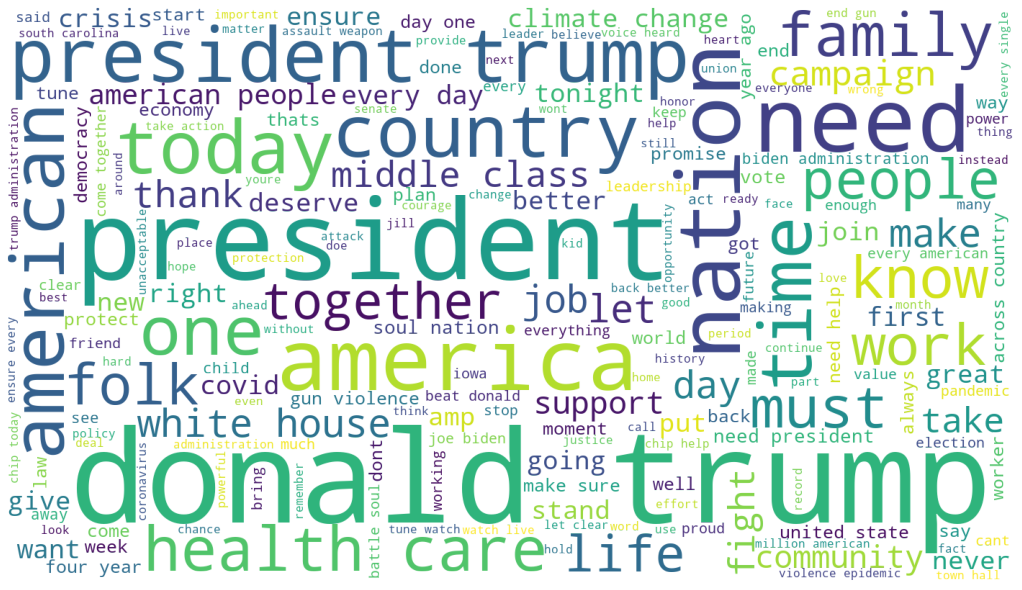

In [815]:
#from worldcloud.query_integral_image import query_integral_image
import matplotlib.pyplot as plt 

clean_words = ' '.join([doc for doc in tweets['clean']])

wordcloud = WordCloud(width = 1400, height = 800, 
                background_color="rgba(255, 255, 255, 0)", mode="RGBA", 
                min_font_size = 10).generate(clean_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (14, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

wordcloud.to_file("wordcloud.png")

Not surprisingly, "president" and "Donald Trump" are the two most occurring words/phrases in Joe Biden's tweets, since the 2020 election was based around a repudiation of Trump and his policies.

----

# Topic Interpretation

I now want to find the most commonly occuring words for each of the 10 topics.

In [532]:
#nmf = NMF(10)
tweet_topic_matrix = nmf.fit_transform(doc_term_matrix)
tweet_topic_matrix_df = pd.DataFrame(tweet_topic_matrix).add_prefix('topic_')

In [533]:
tweets.shape

(4575, 7)

In [534]:
tweet_topic_matrix.shape

(4575, 10)

In [535]:
tweet_topic_matrix_df.shape

(4575, 10)

In [536]:
tweet_topic_matrix_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.001525,0.000000,0.027737,0.099647,0.0,0.035203,0.000000,0.006354,0.000000,0.000000
1,0.000000,0.000000,0.020844,0.138833,0.0,0.001622,0.063516,0.001435,0.000000,0.000000
2,0.000000,0.000000,0.097477,0.022696,0.0,0.040324,0.027946,0.000000,0.000000,0.000000
3,0.000000,0.001324,0.048778,0.003333,0.0,0.018272,0.063200,0.000000,0.016055,0.002239
4,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.119198,0.008678,0.000000,0.000000


In [537]:
word_topic_matrix_df = pd.DataFrame(nmf.components_, columns=tfidf.get_feature_names()).T.add_prefix('topic_')

In [538]:
word_topic_matrix_df.shape

(6456, 10)

In [539]:
def top_tweets(tweet_topic_matrix_df, topic, n_tweets):
    """
    """
    return (tweet_topic_matrix_df
            .sort_values(by=topic, ascending=False)
            .head(n_tweets)['tweet']
            .values)

def top_words(word_topic_matrix_df, topic, n_words):
    """
    """
    return (word_topic_matrix_df
            .sort_values(by=topic, ascending=False)
            .head(n_words))[topic]

#### Topic 0: Trump

In [540]:
top_words(word_topic_matrix_df, 'topic_0', 10)

donald    2.461713
trump     2.343724
year      0.661921
nation    0.542749
four      0.538291
white     0.427240
let       0.412180
house     0.397985
beat      0.385172
failed    0.297302
Name: topic_0, dtype: float64

#### Topic 1: Health Care

In [543]:
top_words(word_topic_matrix_df, 'topic_1', 10)

care          1.260725
health        1.108019
affordable    0.489206
obamacare     0.389594
access        0.383868
protect       0.327556
quality       0.303974
american      0.268621
build         0.267946
ensure        0.260319
Name: topic_1, dtype: float64

#### Topic 2: Voting

In [544]:
top_words(word_topic_matrix_df, 'topic_2', 10)

vote        1.307812
make        0.595663
today       0.583390
early       0.522209
head        0.510187
ballot      0.457569
voice       0.358862
heard       0.338747
election    0.323087
register    0.299354
Name: topic_2, dtype: float64

#### Topic 3: Together/United

In [546]:
top_words(word_topic_matrix_df, 'topic_3', 10)

together    1.213533
america     0.782511
nation      0.545880
thing       0.517458
come        0.463826
single      0.414793
country     0.401419
one         0.380014
united      0.314350
soul        0.285514
Name: topic_3, dtype: float64

#### Topic 4: Gun violence reform

In [547]:
top_words(word_topic_matrix_df, 'topic_4', 10)

gun         1.242803
violence    0.958976
end         0.755761
epidemic    0.735076
weapon      0.427987
take        0.311048
enough      0.309841
assault     0.305886
must        0.302806
pas         0.300811
Name: topic_4, dtype: float64

#### Topic 5: Importance of Presidency

In [550]:
top_words(word_topic_matrix_df, 'topic_5', 15)

president    1.628277
american     0.828871
people       0.512459
need         0.460644
trump        0.256936
job          0.189554
one          0.187984
promise      0.168498
truth        0.162414
covid        0.156063
deserve      0.144979
crisis       0.131033
history      0.129990
life         0.129554
tell         0.126897
Name: topic_5, dtype: float64

#### Topic 6: Donate

In [552]:
top_words(word_topic_matrix_df, 'topic_6', 15)

help        0.940034
day         0.784423
chip        0.755747
campaign    0.565410
need        0.478008
going       0.380271
folk        0.363075
every       0.315268
keep        0.292513
election    0.292342
one         0.279123
make        0.278312
momentum    0.271242
tonight     0.266228
big         0.264341
Name: topic_6, dtype: float64

#### Topic 7: Climate change

In [553]:
top_words(word_topic_matrix_df, 'topic_7', 15)

climate        1.203533
change         0.794652
action         0.559035
take           0.506763
crisis         0.478666
house          0.462641
white          0.451377
threat         0.438290
emergency      0.372663
address        0.351979
world          0.334185
existential    0.330567
planet         0.321135
get            0.262622
future         0.257276
Name: topic_7, dtype: float64

#### Topic 8: Middle class / Workers

In [554]:
top_words(word_topic_matrix_df, 'topic_8', 15)

class       0.774289
middle      0.773993
work        0.606628
time        0.551860
everyone    0.485819
tax         0.461066
rebuild     0.378488
build       0.371054
along       0.317545
wealthy     0.317421
pay         0.311142
back        0.283685
economy     0.261900
wealth      0.253261
better      0.251699
Name: topic_8, dtype: float64

#### Topic 9: Debates

In [555]:
top_words(word_topic_matrix_df, 'topic_9', 15)

tune            1.108361
watch           0.888046
live            0.804299
stage           0.739679
take            0.584538
tonight         0.438363
town            0.324966
hall            0.308248
discus          0.269914
covid           0.201110
join            0.181993
back            0.165150
pennsylvania    0.145548
debate          0.139785
forward         0.122358
Name: topic_9, dtype: float64

---

# Tweet Topics

In [556]:
word_topic_matrix_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
aanhpi,0.0,0.000000,0.000000,0.001818,0.000062,0.000369,0.000000,0.000000,0.000000,0.000081
aapi,0.0,0.001963,0.000000,0.003287,0.000665,0.000000,0.000000,0.000000,0.003354,0.000000
aapis,0.0,0.000000,0.000000,0.002400,0.000000,0.000000,0.001546,0.000000,0.000000,0.000000
aarp,0.0,0.000497,0.000319,0.000000,0.000000,0.002638,0.000000,0.000000,0.000306,0.000052
abandon,0.0,0.000000,0.000000,0.014416,0.000000,0.000000,0.007819,0.009399,0.000000,0.000000


In [558]:
#rename each topic column with our topic names:
topics = ['Trump', 'Healthcare', 'Voting', 'Unite', 'Gun_Reform', 'Presidency', 'Donate',
          'Climate', 'Workers', 'Debates']

word_topic_matrix_df.columns = topics

In [559]:
tweet_topic_matrix_df.columns

Index(['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5',
       'topic_6', 'topic_7', 'topic_8', 'topic_9'],
      dtype='object')

In [560]:
topics_tweets = ['Trump', 'Healthcare', 'Voting', 'Unite', 'Gun_Reform', 'Presidency', 'Donate',
                 'Climate', 'Workers', 'Debates'] 

tweet_topic_matrix_df.columns = topics_tweets

In [561]:
tweet_topic_matrix_df['label'] = tweet_topic_matrix_df.idxmax(axis=1)

In [562]:
tweet_topic_matrix_df[['tweet', 'clean', 'timestamp', 'replies', 'retweets', 'quotes', 'likes']] = tweets[['tweet', 'clean', 'timestamp','replies', 'retweets', 'quotes', 'likes']]

In [563]:
tweet_topic_matrix_df.head()

,Trump,Healthcare,Voting,Unite,Gun_Reform,Presidency,Donate,Climate,Workers,Debates,label,tweet,clean,timestamp,replies,retweets,quotes,likes
0,0.001525,0.000000,0.027737,0.099647,0.0,0.035203,0.000000,0.006354,0.000000,0.000000,Unite,The core values of this nation… our standing i...,core value nation standing world democracy eve...,2019-04-25 10:00:00,18115.0,27217.0,10198.0,94224.0
1,0.000000,0.000000,0.020844,0.138833,0.0,0.001622,0.063516,0.001435,0.000000,0.000000,Unite,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2,0.000000,0.000000,0.097477,0.022696,0.0,0.040324,0.027946,0.000000,0.000000,0.000000,Voting,"Our country is being put to the test, but I’ve...",country put test never optimistic america toge...,2019-04-25 14:51:00,1371.0,3286.0,442.0,14918.0
3,0.000000,0.001324,0.048778,0.003333,0.0,0.018272,0.063200,0.000000,0.016055,0.002239,Donate,"Folks, earlier today I announced that I’m runn...",folk earlier today announced running president...,2019-04-25 17:00:00,1698.0,3589.0,436.0,19515.0
4,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.119198,0.008678,0.000000,0.000000,Donate,Our campaign is off to a great start thanks to...,campaign great start thanks thousand american ...,2019-04-25 20:45:00,1031.0,2257.0,185.0,12486.0


In [564]:
tweet_topic_matrix_df['tweet'].isnull().sum()

137

It looks like there are some null values for some reason. I want to get rid of those.

In [565]:
tweet_topic_matrix_df = tweet_topic_matrix_df.dropna()
tweet_topic_matrix_df.head(3)

,Trump,Healthcare,Voting,Unite,Gun_Reform,Presidency,Donate,Climate,Workers,Debates,label,tweet,clean,timestamp,replies,retweets,quotes,likes
0,0.001525,0.000000,0.027737,0.099647,0.0,0.035203,0.000000,0.006354,0.000000,0.000000,Unite,The core values of this nation… our standing i...,core value nation standing world democracy eve...,2019-04-25 10:00:00,18115.0,27217.0,10198.0,94224.0
2,0.000000,0.000000,0.097477,0.022696,0.0,0.040324,0.027946,0.000000,0.000000,0.000000,Voting,"Our country is being put to the test, but I’ve...",country put test never optimistic america toge...,2019-04-25 14:51:00,1371.0,3286.0,442.0,14918.0
3,0.000000,0.001324,0.048778,0.003333,0.0,0.018272,0.063200,0.000000,0.016055,0.002239,Donate,"Folks, earlier today I announced that I’m runn...",folk earlier today announced running president...,2019-04-25 17:00:00,1698.0,3589.0,436.0,19515.0


Now each tweet (which is a row in the dataframe) has a value for each of the 10 topics, depending how well it fits into that category.

In [567]:
doc_topic

array([[0.00957712, 0.        , 0.02778238, ..., 0.01004107, 0.        ,
        0.00040698],
       [0.        , 0.        , 0.02349637, ..., 0.        , 0.        ,
        0.00052422],
       [0.01011563, 0.        , 0.09880928, ..., 0.        , 0.00206382,
        0.        ],
       ...,
       [0.        , 0.        , 0.20904523, ..., 0.0040668 , 0.00064271,
        0.        ],
       [0.        , 0.02016094, 0.        , ..., 0.00223271, 0.        ,
        0.        ],
       [0.00807014, 0.04615656, 0.        , ..., 0.        , 0.        ,
        0.00049956]])

---

# K-Means Clustering

We can visualize the topics with K-Means clustering.

### 10 topics

In [604]:
def display_cluster(X,km=[],num_clusters=0):
    alpha = 0.5
    s = 20
    color=["tomato", "aquamarine", "yellowgreen", "forestgreen", "orange",
           "yellow", "royalblue", "darkorchid", "gold", "violet", "deeppink"]
    if num_clusters == 0:
        plt.scatter(X[:,0], X[:,1], alpha=alpha, s=s, c=color[0]) 
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0], X[km.labels_==i,1],alpha=alpha, s=s, c=color[i])
            plt.scatter(km.cluster_centers_[i][0], km.cluster_centers_[i][1], marker='x', s=100, c=color[i])

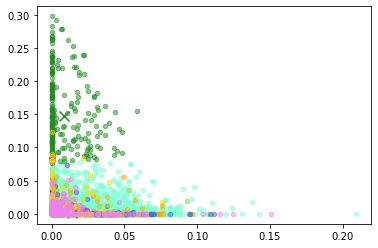

In [606]:
from sklearn.cluster import KMeans

num_clusters = 10 #my original number of topics 
km = KMeans(n_clusters=num_clusters)
km.fit(doc_topic)
display_cluster(doc_topic, km, num_clusters)

In [572]:
km.inertia_

13.645356065195514

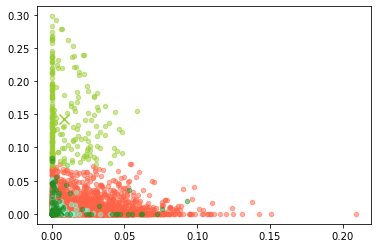

In [607]:
num_clusters = 4 #chosen based on the image above
km = KMeans(n_clusters=num_clusters)
km.fit(doc_topic)

display_cluster(doc_topic, km, num_clusters)

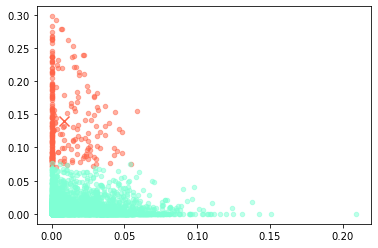

In [611]:
num_clusters = 2
km = KMeans(n_clusters=num_clusters)
km.fit(doc_topic)

display_cluster(doc_topic, km, num_clusters)

In [612]:
km.cluster_centers_

array([[0.00830085, 0.14051969, 0.00919836, 0.00532751, 0.00490875,
        0.00433653, 0.00725912, 0.00648459, 0.01315256, 0.00360885],
       [0.01419488, 0.00739163, 0.01302592, 0.01824142, 0.01052194,
        0.01114729, 0.01773203, 0.01104551, 0.01620028, 0.00984334]])

In [613]:
km.cluster_centers_[0]

array([0.00830085, 0.14051969, 0.00919836, 0.00532751, 0.00490875,
       0.00433653, 0.00725912, 0.00648459, 0.01315256, 0.00360885])

In [614]:
tweet_topic_matrix_df.columns

tweet_topic_df = tweet_topic_matrix_df[['Trump', 'Healthcare', 'Voting', 'Unite', 'Gun_Reform', 
                       'Presidency','Donate', 'Climate', 'Workers', 'Debates']]

In [615]:
tweet_topic_df.head()

,Trump,Healthcare,Voting,Unite,Gun_Reform,Presidency,Donate,Climate,Workers,Debates
0,0.001525,0.000000,0.027737,0.099647,0.000000,0.035203,0.000000,0.006354,0.000000,0.000000
2,0.000000,0.000000,0.097477,0.022696,0.000000,0.040324,0.027946,0.000000,0.000000,0.000000
3,0.000000,0.001324,0.048778,0.003333,0.000000,0.018272,0.063200,0.000000,0.016055,0.002239
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.119198,0.008678,0.000000,0.000000
5,0.000000,0.000000,0.017666,0.000000,0.001148,0.040307,0.019084,0.000000,0.000000,0.121618


In [616]:
from sklearn.metrics.pairwise import cosine_similarity

In [617]:
np.argmax(cosine_similarity(tweet_topic_df, km.cluster_centers_[0].reshape(1,-1)))

417

In [618]:
tweet_topic_matrix_df.tweet[417]

"President Trump’s ICE raids are inhumane. His scare tactics solve nothing. We shouldn't be terrorizing communities and splitting up families. We should provide a pathway to citizenship and find a lasting solution."

In [619]:
np.argmax(cosine_similarity(tweet_topic_df, km.cluster_centers_[1].reshape(1,-1)))

4358

In [620]:
tweet_topic_matrix_df.tweet[4358]

'I am ready to fight for you and for our nation. Every day. Without exception, without reservation. And with a full and devoted heart.'

### Plotting Inertia

In [589]:
import matplotlib.pyplot as plt

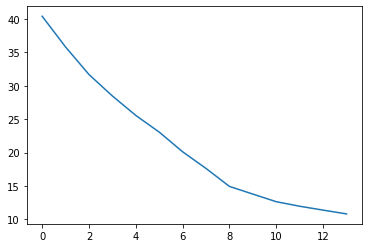

In [591]:
inertias = []
for i in range(1, 15):
    km = KMeans(n_clusters=i)
    km.fit(doc_topic)
    inertia = km.inertia_
    inertias.append(inertia)

plt.plot(inertias)
plt.show()

In [317]:
km.inertia_

17.25026132280205

# PCA

Let's try to visualize the topics in a better way.

In [621]:
from sklearn.decomposition import PCA

In [635]:
tweet_topic_matrix_df.columns

Index(['Trump', 'Healthcare', 'Voting', 'Unite', 'Gun_Reform', 'Presidency',
       'Donate', 'Climate', 'Workers', 'Debates', 'label', 'tweet', 'clean',
       'timestamp', 'replies', 'retweets', 'quotes', 'likes'],
      dtype='object')

In [636]:
doc_topic_matrix = tweet_topic_matrix_df[['Trump', 'Healthcare', 'Voting', 'Unite', 'Gun_Reform', 'Presidency',
                             'Donate', 'Climate', 'Workers', 'Debates']].values

In [691]:
def plot_PCA(data, target, target_names, colors, title=None):
    plt.figure(figsize=(10,10), dpi=100)
    for c, label in zip(colors, target_names):
        plt.scatter(data[target == label, 0], data[target == label, 1],
                   c=c, label=label, alpha=1, s=2)
    lgnd = plt.legend(fontsize=10, prop={'size':12}, loc='upper right', frameon=False)
    
    for i in range(len(target_names)):
        lgnd.legendHandles[i]._sizes = [50]
    
    if title is not None:
        plt.title(title, fontsize=16)
    
    plt.xlabel('PCA Feature 1', fontsize=12)
    plt.ylabel('PCA Feature 2', fontsize=12)
    sns.despine()
    #plt.savefig('../img/lda_pca_plot.png')
    plt.show();

In [692]:
target = tweet_topic_matrix_df['label']
target_names = list(target.unique())
colors = ['red', 'orange', 'gold', 'forestgreen', 'lime', 'aqua', 'dodgerblue', 'mediumblue', 'blueviolet', 'hotpink']

In [693]:
pca = PCA()
pca_features = pca.fit_transform(doc_topic_matrix)

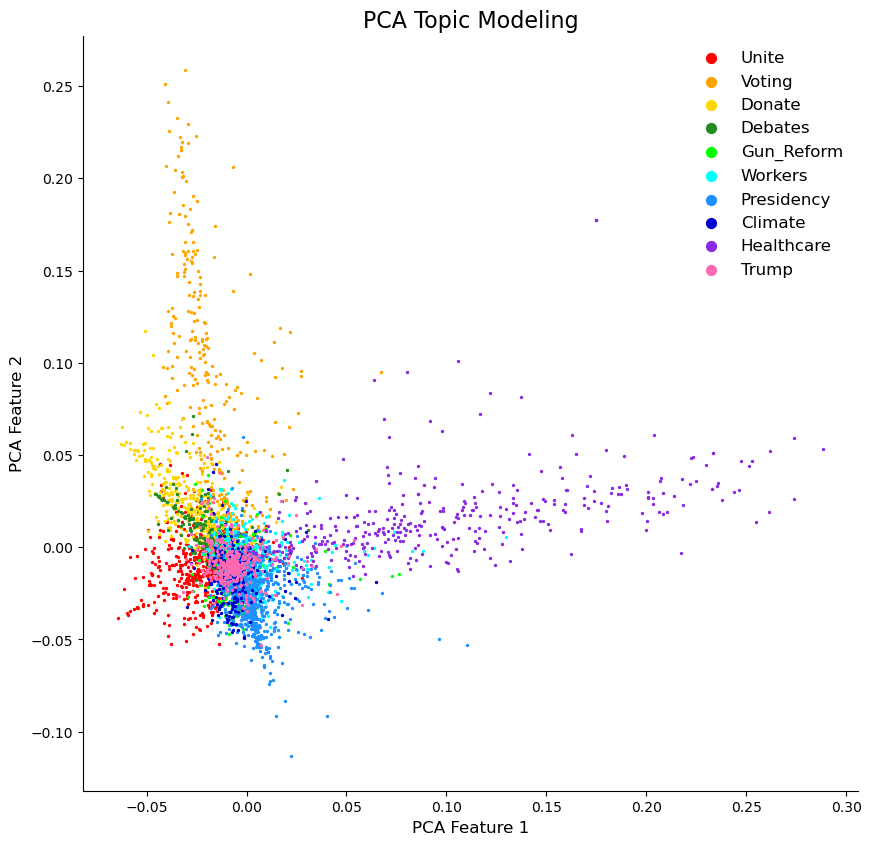

In [694]:
plot_PCA(pca_features, 
         target=target, 
         target_names=target_names, 
         colors=colors, 
         title='PCA Topic Modeling')

# TSNE

In [663]:
from sklearn.manifold import TSNE

In [664]:
tsne_model = TSNE(n_components=2, 
                  perplexity=50,
                  random_state=37,
                  n_jobs=-1)

In [665]:
tsne_nmf = tsne_model.fit_transform(doc_topic_matrix)

In [702]:
def plot_tsne(data, target, target_names, colors, title=None):
    
    plt.figure(figsize=(10, 8), dpi=100)
    for c, label in zip(colors, target_names):
        plt.scatter(data[target == label, 0], data[target == label, 1], c=c, label=label, s=5, alpha=0.5)
    lgnd = plt.legend(fontsize=10, prop={'size':12}, loc='upper right', frameon=False)
    for i in range(len(target_names)):
        lgnd.legendHandles[i]._sizes = [50]
    sns.despine()
    plt.xlim(-50, 65)
    plt.ylim(-50, 65)
    
    if title is not None:
        plt.title(title, fontsize=16)
    
    plt.xlabel("TSNE Feature 1")
    plt.ylabel("TSNE Feature 2")
    plt.savefig('../nmf_tsne_plot.png')
    plt.show();

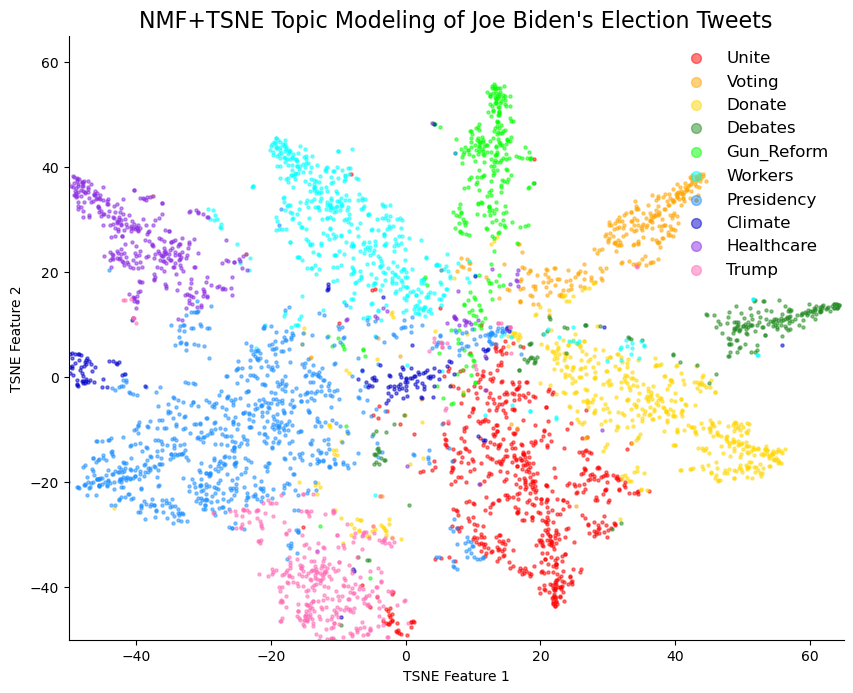

In [703]:
plot_tsne(tsne_nmf, 
          target, 
          target_names, 
          colors, 
          title='NMF+TSNE Topic Modeling of Joe Biden\'s Election Tweets')

I find the TSNE plot especially interesting because of the climate chunk on the side as well as in the middle. Climate activists always claim that climate change is related to every other policy issue (and I would agree), and this is a good demonstration of their point.

# Timeline

I want to create a timeline of tweets under some of the topic areas.

In [746]:
tweet_topic_matrix_df.head(3)

,Trump,Healthcare,Voting,Unite,Gun_Reform,Presidency,Donate,Climate,Workers,Debates,label,tweet,clean,timestamp,replies,retweets,quotes,likes,week,day
0,0.001525,0.000000,0.027737,0.099647,0.0,0.035203,0.000000,0.006354,0.000000,0.000000,Unite,The core values of this nation… our standing i...,core value nation standing world democracy eve...,2019-04-25 10:00:00,18115.0,27217.0,10198.0,94224.0,2019-04 wk 16,2019-04 wk 16
2,0.000000,0.000000,0.097477,0.022696,0.0,0.040324,0.027946,0.000000,0.000000,0.000000,Voting,"Our country is being put to the test, but I’ve...",country put test never optimistic america toge...,2019-04-25 14:51:00,1371.0,3286.0,442.0,14918.0,2019-04 wk 16,2019-04 wk 16
3,0.000000,0.001324,0.048778,0.003333,0.0,0.018272,0.063200,0.000000,0.016055,0.002239,Donate,"Folks, earlier today I announced that I’m runn...",folk earlier today announced running president...,2019-04-25 17:00:00,1698.0,3589.0,436.0,19515.0,2019-04 wk 16,2019-04 wk 16


In [777]:
tweet_topic_matrix_df['day'] = tweet_topic_matrix_df['timestamp'].dt.strftime('%Y-%m-%d')

In [781]:
tweet_topic_matrix_df.head(3)

,Trump,Healthcare,Voting,Unite,Gun_Reform,Presidency,Donate,Climate,Workers,Debates,label,tweet,clean,timestamp,replies,retweets,quotes,likes,week,day
0,0.001525,0.000000,0.027737,0.099647,0.0,0.035203,0.000000,0.006354,0.000000,0.000000,Unite,The core values of this nation… our standing i...,core value nation standing world democracy eve...,2019-04-25 10:00:00,18115.0,27217.0,10198.0,94224.0,2019-04 (wk 16),2019-04-25
2,0.000000,0.000000,0.097477,0.022696,0.0,0.040324,0.027946,0.000000,0.000000,0.000000,Voting,"Our country is being put to the test, but I’ve...",country put test never optimistic america toge...,2019-04-25 14:51:00,1371.0,3286.0,442.0,14918.0,2019-04 (wk 16),2019-04-25
3,0.000000,0.001324,0.048778,0.003333,0.0,0.018272,0.063200,0.000000,0.016055,0.002239,Donate,"Folks, earlier today I announced that I’m runn...",folk earlier today announced running president...,2019-04-25 17:00:00,1698.0,3589.0,436.0,19515.0,2019-04 (wk 16),2019-04-25


In [756]:
labeled_tweets = tweet_topic_matrix_df[['label', 'tweet','month']]

In [757]:
labeled_tweets.head()

,label,tweet,week
0,Unite,The core values of this nation… our standing i...,2019-04 (wk 16)
2,Voting,"Our country is being put to the test, but I’ve...",2019-04 (wk 16)
3,Donate,"Folks, earlier today I announced that I’m runn...",2019-04 (wk 16)
4,Donate,Our campaign is off to a great start thanks to...,2019-04 (wk 16)
5,Debates,UPDATE: We’re about to close the books on an A...,2019-04 (wk 16)


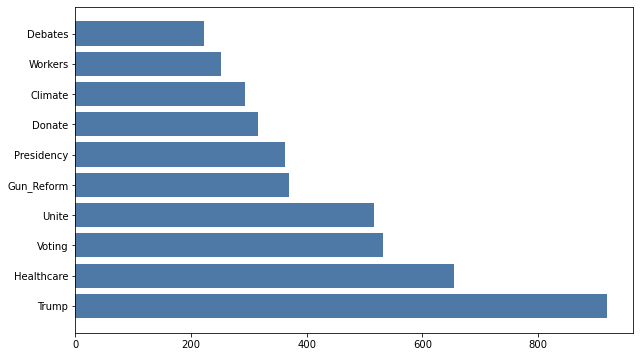

In [807]:
labels = ['Trump', 'Healthcare', 'Voting', 'Unite', 'Gun_Reform', 'Presidency', 'Donate',
          'Climate', 'Workers', 'Debates'] 

top_freq = list(labeled_tweets['label'].value_counts())

plt.figure(figsize=(10, 6))
plt.barh(labels, top_freq, color='#4e79a7')
#plt.xlabel('Tweet Count', fontsize=12)
#plt.title("Topic Frequency", fontsize=16);

plt.savefig('topic_frequency.png', transparent=True)

In [759]:
date_freq = labeled_tweets.groupby(['week', 'label']).size().unstack().reset_index()

In [760]:
date_freq.fillna(0, inplace=True)
date_freq['total'] = date_freq.sum(axis=1)

In [761]:
date_freq

label,week,Climate,Debates,Donate,Gun_Reform,Healthcare,Presidency,Trump,Unite,Voting,Workers,total
0,2019-04 (wk 16),0.0,1.0,4.0,1.0,0.0,1.0,0.0,2.0,2.0,4.0,15.0
1,2019-04 (wk 17),1.0,0.0,2.0,1.0,2.0,2.0,0.0,0.0,0.0,9.0,17.0
2,2019-05 (wk 17),1.0,0.0,6.0,1.0,0.0,0.0,0.0,3.0,1.0,2.0,14.0
3,2019-05 (wk 18),3.0,1.0,8.0,3.0,0.0,0.0,0.0,2.0,3.0,4.0,24.0
4,2019-05 (wk 19),1.0,4.0,3.0,2.0,2.0,3.0,0.0,10.0,0.0,6.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...
90,2020-09 (wk 39),1.0,10.0,5.0,4.0,1.0,8.0,3.0,10.0,8.0,3.0,53.0
91,2020-10 (wk 39),1.0,1.0,3.0,1.0,3.0,10.0,2.0,5.0,5.0,5.0,36.0
92,2020-10 (wk 40),3.0,4.0,12.0,1.0,8.0,23.0,2.0,15.0,31.0,2.0,101.0
93,2020-10 (wk 41),2.0,4.0,15.0,1.0,4.0,26.0,7.0,14.0,28.0,6.0,107.0


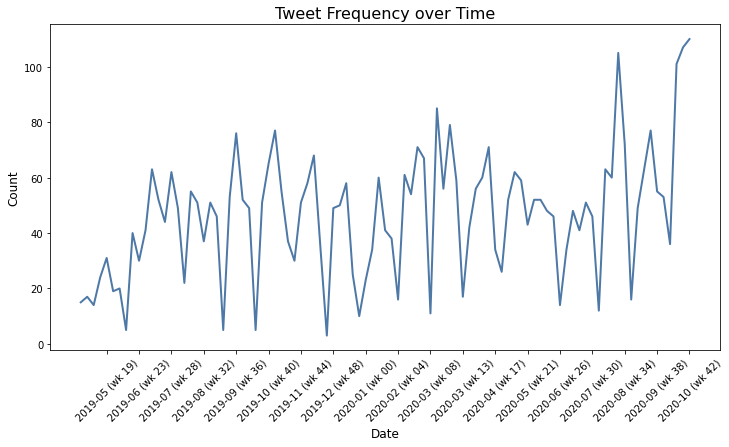

In [762]:
dates = date_freq.week
total_tweets = date_freq.total
x_ticks = list(date_freq.week.unique()[-1::-5])

plt.figure(figsize=(12, 6))
plt.plot(dates, total_tweets, color='#4e79a7', linewidth=2)
plt.title('Tweet Frequency over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(x_ticks, rotation=45);

In [763]:
date_freq.columns

Index(['week', 'Climate', 'Debates', 'Donate', 'Gun_Reform', 'Healthcare',
       'Presidency', 'Trump', 'Unite', 'Voting', 'Workers', 'total'],
      dtype='object', name='label')

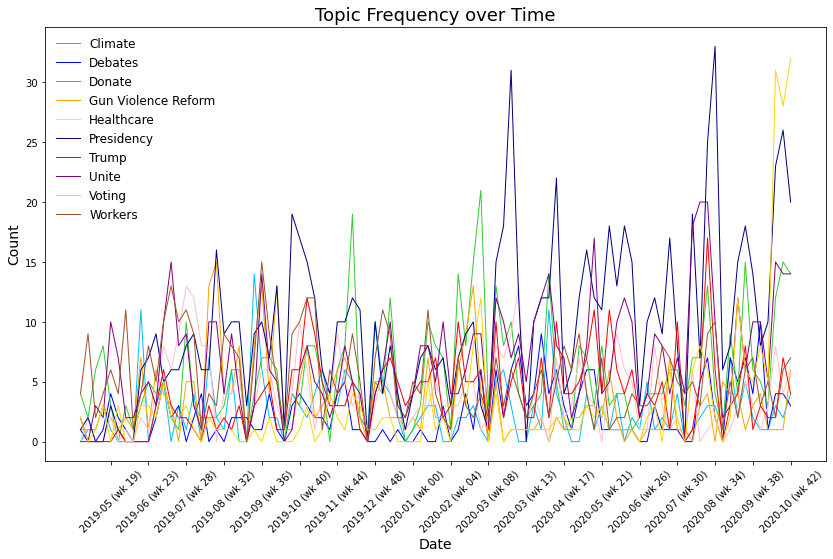

In [850]:
dates = date_freq.week
x_ticks = list(date_freq.week.unique()[-1::-5])

Climate = date_freq.Climate
Debates = date_freq.Debates
Donate = date_freq.Donate
Gun_Reform = date_freq.Gun_Reform
Healthcare = date_freq.Healthcare
Presidency = date_freq.Presidency
Trump = date_freq.Trump
Unite = date_freq.Unite
Voting = date_freq.Voting
Workers = date_freq.Workers


plt.figure(figsize=(14, 8))

plt.plot(dates, Climate, color='deepskyblue', linewidth=1, label='Climate')
plt.plot(dates, Debates, color='blue', linewidth=1, label='Debates')
plt.plot(dates, Donate, color='limegreen', linewidth=1, label='Donate')
plt.plot(dates, Gun_Reform, color='orange', linewidth=1, label='Gun Violence Reform')
plt.plot(dates, Healthcare, color='pink', linewidth=1, label='Healthcare')
plt.plot(dates, Presidency, color='navy', linewidth=1, label='Presidency')
plt.plot(dates, Trump, color='red', linewidth=1, label='Trump')
plt.plot(dates, Unite, color='purple', linewidth=1, label='Unite')
plt.plot(dates, Voting, color='gold', linewidth=1, label='Voting')
plt.plot(dates, Workers, color='sienna', linewidth=1, label='Workers')


plt.title('Topic Frequency over Time', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(x_ticks, rotation=45)
plt.legend(loc='upper left', frameon=False, fontsize=12);

# Voting Topic

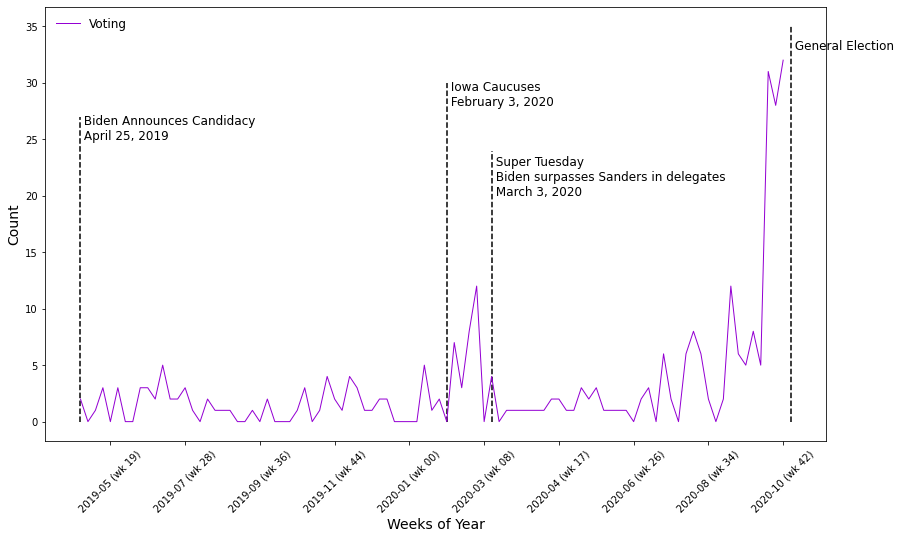

In [841]:
dates = date_freq.week
x_ticks = list(date_freq.week.unique()[-1::-10])

#Debates = date_freq.Debates
#Donate = date_freq.Donate
#Trump = date_freq.Trump
Voting = date_freq.Voting


plt.figure(figsize=(14, 8))

#plt.plot(dates, Debates, color='blue', linewidth=1, label='Debates')
#plt.plot(dates, Donate, color='limegreen', linewidth=1, label='Donate')
#plt.plot(dates, Trump, color='red', linewidth=1, label='Trump')
plt.plot(dates, Voting, color='darkviolet', linewidth=1, label='Voting')

plt.vlines('2019-04 (wk 16)', ymin=0, ymax=27, linestyle='--', color='black')
plt.text('2019-04 (wk 16)', 25, ' Biden Announces Candidacy \n April 25, 2019', rotation=0, fontsize=12)

plt.vlines('2020-02 (wk 04)', ymin=0, ymax=30, linestyle='--', color='black')
plt.text('2020-02 (wk 04)', 28, ' Iowa Caucuses \n February 3, 2020', rotation=0, fontsize=12)

plt.vlines('2020-03 (wk 09)', ymin=0, ymax=24, linestyle='--', color='black')
plt.text('2020-03 (wk 09)', 20, ' Super Tuesday \n Biden surpasses Sanders in delegates \n March 3, 2020', rotation=0, fontsize=12)

plt.vlines('2020-11 (wk 43)', ymin=0, ymax=35, linestyle='--', color='black')
plt.text('2020-11 (wk 43)', 33, ' General Election', rotation=0, fontsize=12)


#plt.title('Topic Frequency over Time', fontsize=18)
plt.xlabel('Weeks of Year', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(x_ticks, rotation=45)

plt.legend(loc='upper left', frameon=False, fontsize=12);
plt.savefig('topic_frequency_voting.png', transparent=True)

# Healthcare Topic

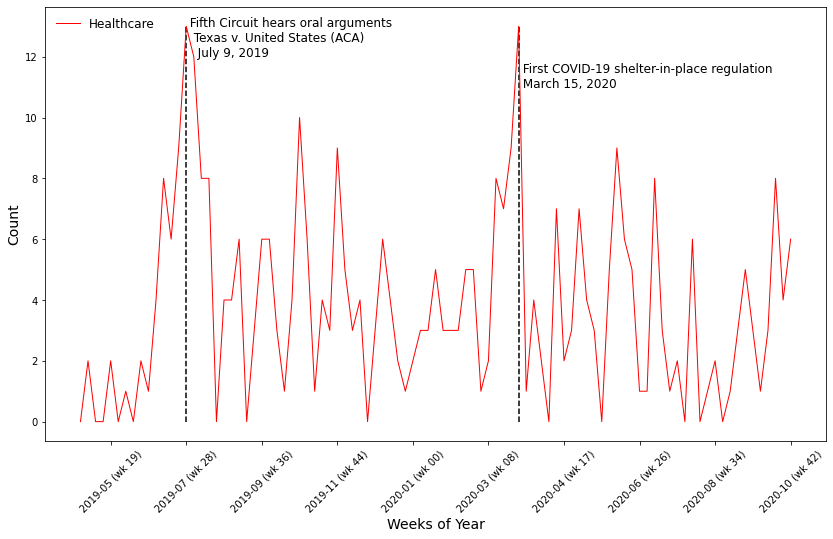

In [847]:
dates = date_freq.week
x_ticks = list(date_freq.week.unique()[-1::-10])

#Debates = date_freq.Debates
#Donate = date_freq.Donate
Healthcare = date_freq.Healthcare
#Trump = date_freq.Trump


plt.figure(figsize=(14, 8))

#plt.plot(dates, Debates, color='blue', linewidth=1, label='Debates')
#plt.plot(dates, Donate, color='limegreen', linewidth=1, label='Donate')
plt.plot(dates, Healthcare, color='red', linewidth=1, label='Healthcare')
#plt.plot(dates, Trump, color='red', linewidth=1, label='Trump')

plt.vlines('2019-07 (wk 28)', ymin=0, ymax=13, linestyle='--', color='black')
plt.text('2019-07 (wk 28)', 12, ' Fifth Circuit hears oral arguments \n  Texas v. United States (ACA) \n   July 9, 2019', rotation=0, fontsize=12)

plt.vlines('2020-03 (wk 12)', ymin=0, ymax=13, linestyle='--', color='black')
plt.text('2020-03 (wk 12)', 11, ' First COVID-19 shelter-in-place regulation \n March 15, 2020', rotation=0, fontsize=12)


#plt.title('Topic Frequency over Time', fontsize=18)
plt.xlabel('Weeks of Year', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(x_ticks, rotation=45)
plt.legend(loc='upper left', frameon=False, fontsize=12);

plt.savefig('topic_frequency_healthcare.png', transparent=True)

In [ ]:
#date_freq = labeled_tweets.groupby(['week']).size().unstack().reset_index()
#date_freq.fillna(0, inplace=True)